In [11]:
%%html
<style>
.h1_cell, .just_text {
    box-sizing: border-box;
    padding-top:5px;
    padding-bottom:5px;
    font-family: "Times New Roman", Georgia, Serif;
    font-size: 125%;
    line-height: 22px; /* 5px +12px + 5px */
    text-indent: 25px;
    background-color: #fbfbea;
    padding: 10px;
}

hr { 
    display: block;
    margin-top: 0.5em;
    margin-bottom: 0.5em;
    margin-left: auto;
    margin-right: auto;
    border-style: inset;
    border-width: 2px;
}
</style>

<h1>
<center>
Module 8: K-NN
</center>
</h1>
<div class=h1_cell>

You will be working with the loan table again.

</div>

In [1]:
import pandas as pd
import os

week = 7

home_path =  os.path.expanduser('~')

file_path = '/Desktop/CIS399/'

file_name = 'loan_wrangled_w'+str(week)+'.csv'

loan_table = pd.read_csv(home_path + file_path + file_name)

league_table = pd.read_csv(home_path + file_path + 'League2.csv')

In [2]:
os.chdir(home_path + file_path + 'datascience_1/')
!git pull

Username for 'https://github.com': ^C


In [4]:
#load the lbirary from content this week

import sys
sys.path.append(home_path + file_path + 'datascience_1/') 
from week7 import *
%who function

accuracy	 build_pred	 build_tree_iter	 caser	 closest_centroid	 compute_mean	 compute_prediction	 compute_training	 euclidean_distance	 
f1	 find_best_splitter	 forest_builder	 generate_table	 gig	 gini	 informedness	 initialize_centroids	 k_fold	 
k_means	 phase_1	 phase_2	 predictor_case	 probabilities	 row_to_vect	 seeder	 tree_predictor	 vote_taker	 



In [5]:
pd.set_option('display.max_columns', None)
loan_table.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,no_lam,filled_lam,pa_Rural,pa_Semiurban,pa_Urban,pa_nan,bin_lam,bin_Low,bin_Average,bin_High,ch_bad,ch_good,ch_nan,apin_binned,apin_Low,apin_Average,apin_High,apin_nan,dep_0,dep_1,dep_2,dep_3+
0,Male,No,0,Graduate,No,5849,0.0,122.322222,360.0,1.0,Urban,1,1,146.412162,0,0,1,0,Low,1,0,0,0,1,0,Low,1,0,0,0,1,0,0,0
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,0,0,128.000000,1,0,0,0,Low,1,0,0,0,1,0,Low,1,0,0,0,0,1,0,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,1,0,66.000000,0,0,1,0,Low,1,0,0,0,1,0,Low,1,0,0,0,1,0,0,0
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,1,0,120.000000,0,0,1,0,Low,1,0,0,0,1,0,Low,1,0,0,0,1,0,0,0
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,1,0,141.000000,0,0,1,0,Low,1,0,0,0,1,0,Low,1,0,0,0,1,0,0,0


In [6]:
features_used = [
        #Income
       'ApplicantIncome', 'CoapplicantIncome',
        #Property_Area
        'pa_Rural', 'pa_Semiurban','pa_Urban'
        ]


In [7]:
target = 'Loan_Status'

<h1>
Implement K-NN please
</h1>
<div class=h1_cell>
Scroll down to see what I want you to match against. If you get stuck, let me know.
<p>
And one debugging note. Because of that O(n**2), you might want to use just a small slice of loan_table until you are happy with results. Then you can try on full table and match my results.
</div>

In [35]:
def voter(lst):
    return max(set(lst), key=lst.count) # return most frequent occurances allows for multilabel classification (not just 0's and 1's like vote_taker does)
# this is SLOW https://stackoverflow.com/questions/1518522/python-most-common-element-in-a-list
#Faster examples mentioned on that post that use libraries

    
def KNN(table, target, features_used, k, row):
    firstvec = row_to_vect(table.iloc[row], features_used) # the vector passed in, this is removed from the table that we compare it to 
    
    new_table = table.drop(table.index[row])


    distlist = []
    for i in range(0, len(new_table)):
        othervec = row_to_vect(new_table.iloc[i], features_used) # 
        distlist.append((euclidean_distance(firstvec, othervec), i))

    #Since we are only interested in the minimum, a full sort, which is in O(nlogn) time, is not necessary.
    #There are methods that can return "K smallest numbers" in O(N) time which would likely make this faster, but I'll use sorted to try to replicate the time you took 
    votelist_index = sorted(distlist)[:k] #tuple of distance at 0th and index at 1st 
    
    votelist = []
    for vote in votelist_index:
        vote_index = vote[1]
        votelist.append(new_table.iloc[vote_index][target]) #the predicted value at this location

    #print(votelist)

    prediction = voter(votelist)

    #print(prediction)
    return(prediction)



##################### I decided to optimize this for funzies to see if I could, and boy I could! 

# BOOM, NUMPY IS AWESOME 
# ~2.5 seconds total on 800 sized dataset with 5 features, 
# Just gotta rely on highly optimized numpy to do the lifting
from collections import Counter
from heapq import nsmallest 
import math
import numpy as np
import bottleneck as bp # faster than numpy 
from numba import njit, prange

def better_voter(lst): # according to this, this is very fast https://stackoverflow.com/a/20872750 
    data = Counter(lst)
    return data.most_common(1)[0][0]

@njit(fastmath=True, parallel=True)
def euc_dist_better(vec1, vec2):
    return np.linalg.norm(vec1-vec2) #numpy is BLAZING FAST and doesn't need row_to_vect, https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
    #return math.sqrt(np.sum((vec1-vec2)**2)) #might be faster on some platforms, I get 0.1 sec improvement
    
def euc_dist_better_less_func_Calls(pointA, pointB, _norm=np.linalg.norm): # slightly faster
    return _norm(pointA - pointB)



def euclidean_dist_square(x, y): # getting rid of the square root is much faster and doesn't change our results
    diff = np.array(x) - np.array(y)
    return np.dot(diff, diff)


def KNN_better(table, target, features_used, k, row):
    firstvec = table[features_used].values[row] # the vector passed in, this is removed from the table that we compare it to 
    
    new_table = table.drop(table.index[row])
    othervec_2 = new_table[features_used].values # I was recalculating this in the forloop which was silly, when it got moved out here this got BLAZING FAST

    distlist = []
    for i in prange(0, len(new_table)):
        othervec = othervec_2[i] # just index that fool!
        #distval = euc_dist_better(firstvec, othervec)
        distval = euc_dist_better(firstvec, othervec)
        #print(distval)
        distlist.append(distval)
        #distlist.append((distval, i))
    dist_list_array = np.asarray(distlist)


    #votelist_index = nsmallest(k, distlist, key=lambda x: x[0]) # O(nlogn but fast)
    
    #ind = np.argpartition(dist_list_array, k)[:k] #O(n) partial sort which seems to return duplicates so slightly diff results 
    ind = bp.argpartition(dist_list_array, k)[:k] # fastest O(n) and no duplicates!
######## for O(nlogn sort)
#     votelist = []
#     for vote in votelist_index:
#         vote_index = vote[1]
#         votelist.append(new_table.iloc[vote_index][target]) #the predicted value at this location

    votelist = []
    for vote in ind:
        votelist.append(new_table.iloc[vote][target])
    #print(votelist)
    prediction = better_voter(votelist)
#     print(prediction)
    return(prediction)

print(KNN_better(loan_table, target, features_used, 5, 1))

# resultslist = []
# for j in range(0, len(loan_table)):
#     resultslist.append(KNN(loan_table, target, features_used, 10, j))


# [[x,resultslist.count(x)] for x in set(resultslist)]


#result_df = loan_table.apply(lambda row: KNN(loan_table, target, features_used, 5, row), axis=1)




1


In [146]:
import scipy 
from scipy import spatial
from sklearn.preprocessing import robust_scale, scale, normalize, minmax_scale
from collections import defaultdict

def weighted_vote(vote_dict):
    testDict = defaultdict(int)
    for key, val in vote_dict:
        testDict[key] += val
    return max(testDict.items(), key=lambda a: a[1])

def weighted_prob(vote_dict, total_weight):
    testDict = defaultdict(int)
    listoftup = []
    for key, val in vote_dict:
        testDict[key] += val
    for key, val in testDict.items():
        t = total_weight/val
        newtup = (key, 1/float(t))
        listoftup.append(newtup)
    return sorted(listoftup, key=lambda x:(-x[1],x[0]))


def get_total_weights(list_of_tup):
    weights = [sum(x) for x in zip(*list_of_tup)]
    return weights

def KNN_best(table, target, features_used, nn):
    k_nn = nn + 1 
    tab_arr = table[features_used].values
    knn_tree = scipy.spatial.cKDTree(tab_arr, )
    #knn_tree = KDTree(tab_arr, leaf_size=16)
    predictionlist = []
    for i in range(0, len(table)):
        tab_first = table[features_used].values[i]
        K_nn_list = list(knn_tree.query(tab_first, k=k_nn, p = 2)[1][1:])
        #K_nn_dist_list_weighted = list(1/knn_tree.query(tab_first, k=k_nn, p = 2)[0][1:]) # returns the largest weights 
        #K_nn_list = list(knn_tree.query(tab_first, k=k_nn, return_distance=False, dualtree=True, breadth_first=False))
        #print(K_nn_list)
        #print(K_nn_dist_list_weighted)
        votelist = []
        for vote in K_nn_list:
            votelist.append(table.iloc[vote][target])
        prediction = better_voter(votelist)
        predictionlist.append(prediction)
        #print(votelist)
    return predictionlist

def KNN_best_weighted(table, target, features_used, nn, scaled, weighted, prob):
    k_nn = nn + 1 
    tab_arr = table[features_used].values
    if scaled == True:     
        scaled_arr = robust_scale(tab_arr)
        knn_tree = scipy.spatial.cKDTree(scaled_arr, )
    else:
        knn_tree = scipy.spatial.cKDTree(tab_arr, )
    predictionlist = []
    probabilitylist = []
    for i in range(0, len(table)):
        tab_first = table[features_used].values[i]
        K_nn_list = list(knn_tree.query(tab_first, k=k_nn, p = 2)[1][1:])
        K_nn_dist_list_weighted = list(1/knn_tree.query(tab_first, k=k_nn, p = 2)[0][1:]) # returns the largest weights 
        #K_nn_list = list(knn_tree.query(tab_first, k=k_nn, return_distance=False, dualtree=True, breadth_first=False))
        #print(K_nn_list)
        #print(K_nn_dist_list_weighted)
        votelist = []
        for vote in K_nn_list:
            votelist.append(table.iloc[vote][target])
        vote_dict = (zip(votelist, K_nn_dist_list_weighted))
        #print(vote_dict)
        
        if weighted == True:
            prediction = weighted_vote(vote_dict)[0]
        elif weighted == False:    
            prediction = better_voter(votelist)
            
        predictionlist.append(prediction)
        if prob == True:
            total_weight = get_total_weights(vote_dict)[1]
            #print(total_weight)
            probability = weighted_prob(vote_dict, total_weight) ## TODO, MAKE THIS WORK PROPERLY WITH UNWEIGHTED
            probabilitylist.append(probability)
    
    return predictionlist, probabilitylist

# loan_tab_arr =  loan_table[features_used].values

# loan_tab_tree = scipy.spatial.cKDTree(loan_tab_arr)
# loan_tab_arr_0 =  loan_table[features_used].values[2]
# K_nn_list = list(loan_tab_tree.query(loan_tab_arr_0, k=4, p = 2)[1][1:])
# K_nn_dist_list_weighted = list(1/loan_tab_tree.query(loan_tab_arr_0, k=4, p = 2)[0][1:])
# votelist = []
# for vote in K_nn_list:
#     votelist.append(loan_table.iloc[vote]["Loan_Status"])
# vote_dict = (zip(votelist, K_nn_dist_list_weighted))
# print(weighted_vote(vote_dict)[0])
# #prediction = better_voter(votelist)
# #print(prediction)



for val in KNN_best_weighted(loan_table, target, features_used, 3, False, False, True)[1]:
    print(val)
  

#mylist = [(3,4), (4,6), (8,2)]
#print(weighted_prob(mylist, 12))

#print(robust_scale(loan_table[features_used].values))

/home/lain/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in divide
/home/lain/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


[(1, 1.0)]
[(1, 1.0)]
[(1, 0.7540737647963127), (0, 0.24592623520368725)]
[(1, 1.0)]
[(0, 0.0), (1, nan)]
[(1, 1.0)]
[(1, 0.7179594210994537), (0, 0.2820405789005462)]
[(1, 0.671528022965502), (0, 0.3284719770344981)]
[(1, 1.0)]
[(1, 1.0)]
[(1, 1.0)]
[(0, 0.7445299065203989), (1, 0.2554700934796011)]
[(1, 0.6282035293852465), (0, 0.37179647061475346)]
[(0, 0.8506773437059248), (1, 0.1493226562940751)]
[(1, 1.0)]
[(0, 0.8688068710733379), (1, 0.13119312892666216)]
[(0, 1.0)]
[(0, 0.542058787129553), (1, 0.45794121287044703)]
[(1, 1.0)]
[(0, 0.8833223212020636), (1, 0.11667767879793643)]
[(1, 1.0)]
[(1, 1.0)]
[(1, 0.6379158307985767), (0, 0.3620841692014232)]
[(1, 1.0)]
[(1, 1.0)]
[(1, 1.0)]
[(1, 1.0)]
[(1, 0.6680979252680279), (0, 0.3319020747319722)]
[(0, 0.7168970839542483), (1, 0.28310291604575166)]
[(1, 0.7057740781756658), (0, 0.29422592182433427)]
[(1, 1.0)]
[(1, 1.0)]
[(1, 1.0)]
[(1, 1.0)]
[(0, 0.6573178037408106), (1, 0.34268219625918944)]
[(1, 1.0)]
[(1, 1.0)]
[(1, 0.6736582877

<h1>
Here are some of my results.
</h1>
<div class=h1_cell>

There is no randomness going on so your results should look the same.
<p>
First I generated a new column `knn5_pred`. I have an average Mac laptop and it took me about 90 seconds. I put a print statement in my knn function to print a message everytime it processed 10 rows. You are not required to do this.
<p>
Just to be clear, I'd like you to match my results for K-NN of 5, 10 and 3 as seen below.
</div>

In [145]:
import time
from sklearn.metrics import accuracy_score, classification_report
target = "Loan_Status"
start = time.time()

#resultslist = []
#for j in range(0, len(loan_table)):
#    resultslist.append(KNN_better(loan_table, target, features_used, 3, j))
resultslist = KNN_best_weighted(loan_table, target, features_used, 3, False, True, True)[0]

end = time.time()
print(end - start)  # This should be FAST!

#print(resultslist)

true_list = list(loan_table[target])

accuracy = accuracy_score(true_list, resultslist)
print(accuracy)
print(classification_report(true_list, resultslist))
# se = pd.Series(resultslist)
# loan_table['knn_3_weighted'] = se.values
# loan_table['knn_3_weighted'].value_counts() 

# loan_table['knn3_weighted_type'] = loan_table.apply(lambda row: predictor_case(row, pred='knn_3_weighted', target='Loan_Status'), axis=1)
# knn3_types_weighted = loan_table['knn3_weighted_type'].value_counts()  # returns a series
# print((accuracy(knn3_types_weighted), f1(knn3_types_weighted), informedness(knn3_types_weighted)))

/home/lain/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in divide
/home/lain/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


0.699844837189
0.600977198697
             precision    recall  f1-score   support

          0       0.33      0.27      0.30       192
          1       0.69      0.75      0.72       422

avg / total       0.58      0.60      0.59       614



<h1>
Here are my results
</h1>
<div class=h1_cell>

You should see the same.

</div>

In [20]:
import time
start = time.time()


resultslist2 = []
for j in range(0, len(loan_table)):
    resultslist2.append(KNN_better(loan_table, target, features_used, 5, j))

se2 = pd.Series(resultslist2)
loan_table['knn5_pred']= se2.values

print(loan_table['knn5_pred'].value_counts())

end = time.time()
print(end - start)  # in seconds

1    504
0    110
Name: knn5_pred, dtype: int64
4.26513814926


In [51]:
loan_table.head(10) 

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,no_lam,filled_lam,pa_Rural,pa_Semiurban,pa_Urban,pa_nan,bin_lam,bin_Low,bin_Average,bin_High,ch_bad,ch_good,ch_nan,apin_binned,apin_Low,apin_Average,apin_High,apin_nan,dep_0,dep_1,dep_2,dep_3+,knn5_pred,knn5_type
0,Male,No,0,Graduate,No,5849,0.0,122.322222,360.0,1.0,Urban,1,1,146.412162,0,0,1,0,Low,1,0,0,0,1,0,Low,1,0,0,0,1,0,0,0,1,true_positive
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,0,0,128.000000,1,0,0,0,Low,1,0,0,0,1,0,Low,1,0,0,0,0,1,0,0,1,false_positive
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,1,0,66.000000,0,0,1,0,Low,1,0,0,0,1,0,Low,1,0,0,0,1,0,0,0,1,true_positive
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,1,0,120.000000,0,0,1,0,Low,1,0,0,0,1,0,Low,1,0,0,0,1,0,0,0,1,true_positive
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,1,0,141.000000,0,0,1,0,Low,1,0,0,0,1,0,Low,1,0,0,0,1,0,0,0,1,true_positive
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.000000,360.0,1.0,Urban,1,0,267.000000,0,0,1,0,Average,0,1,0,0,1,0,Low,1,0,0,0,0,0,1,0,1,true_positive
6,Male,Yes,0,Not Graduate,No,2333,1516.0,95.000000,360.0,1.0,Urban,1,0,95.000000,0,0,1,0,Low,1,0,0,0,1,0,Low,1,0,0,0,1,0,0,0,1,true_positive
7,Male,Yes,3+,Graduate,No,3036,2504.0,158.000000,360.0,0.0,Semiurban,0,0,158.000000,0,1,0,0,Low,1,0,0,1,0,0,Low,1,0,0,0,0,0,0,1,1,false_positive
8,Male,Yes,2,Graduate,No,4006,1526.0,168.000000,360.0,1.0,Urban,1,0,168.000000,0,0,1,0,Low,1,0,0,0,1,0,Low,1,0,0,0,0,0,1,0,1,true_positive
9,Male,Yes,1,Graduate,No,12841,10968.0,349.000000,360.0,1.0,Semiurban,0,0,349.000000,0,1,0,0,Average,0,1,0,0,1,0,Low,1,0,0,0,0,1,0,0,0,true_negative


In [52]:
loan_table['knn5_type'] = loan_table.apply(lambda row: predictor_case(row, pred='knn5_pred', target='Loan_Status'), axis=1)
knn5_types = loan_table['knn5_type'].value_counts()  # returns a series
print((accuracy(knn5_types), f1(knn5_types), informedness(knn5_types)))

(0.6302931596091205, 0.7566988210075026, 0.013576224328593955)


<hr>
<h2>
Now I will try with K = 10
</h2>
<p>
<div class=h1_cell>
<p>
My assumption that it will still take about 1.5 minutes because I still have to do the same O(n**2) computations. K is somewhat irrelevant.
</div>

In [19]:

start = time.time()

resultslist3 = []
for j in range(0, len(loan_table)):
    resultslist3.append(KNN(loan_table, target, features_used, 10, j))

se3 = pd.Series(resultslist3)
loan_table['knn10_pred']= se3.values

end = time.time()
print(end - start)  # in seconds

68.7543079853


In [20]:
loan_table['knn10_pred'].value_counts()

1    511
0    103
Name: knn10_pred, dtype: int64

In [21]:
loan_table['knn10_type'] = loan_table.apply(lambda row: predictor_case(row, pred='knn10_pred', target='Loan_Status'), axis=1)
knn10_types = loan_table['knn10_type'].value_counts()  # returns a series
print((accuracy(knn10_types), f1(knn10_types), informedness(knn10_types)))

(0.6302931596091205, 0.7566988210075026, 0.013576224328593955)


<hr>
<h2>
Slightly worse!
</h2>
<p>
<div class=h1_cell>
<p>
Ok, one more try with K=3.
</div>

In [22]:
start = time.time()

resultslist4 = []
for j in range(0, len(loan_table)):
    resultslist4.append(KNN(loan_table, target, features_used, 3, j))

se4 = pd.Series(resultslist4)
loan_table['knn3_pred']= se4.values

end = time.time()
print(end - start)  # in seconds

69.2329421043


In [23]:
loan_table['knn3_pred'].value_counts()

1    482
0    132
Name: knn3_pred, dtype: int64

In [24]:
loan_table['knn3_type'] = loan_table.apply(lambda row: predictor_case(row, pred='knn3_pred', target='Loan_Status'), axis=1)
knn3_types = loan_table['knn3_type'].value_counts()  # returns a series
print((accuracy(knn3_types), f1(knn3_types), informedness(knn3_types)))

(0.6058631921824105, 0.7323008849557522, -0.0020981437598736052)


<hr>
<h2>
Not good
</h2>
<p>
<div class=h1_cell>
<p>
Still going down.
<p>
Why so bad? Normally K-NN fails when there are many features/columns in play. It relies on distances, and the more columns you add, the harder to discern distance differences. This is an example of the curse of dimensionality (jargon alert). Here is an intro to the problem: http://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/. But the thing is, we have a low number of columns, so that it is not the issue. I'd argue we have the opposite problem: the curse of low dimensionality (I just made that up.). We only have 2 numeric columns and other 3 are binary. I conjecture if we added more columns, we would do better. But I won't make you do that. However, if someone wants to give it a shot, I'll give you extra credit. You will have to deal with empties in the other columns though.
</div>

In [25]:
league_table.head()
#print(len(league_table))

,Champion_name,side,kills,deaths,assists,CS,level,first_blood,gold_earned,magic_dmg_delt,physical_dmg_delt,lane,role,win
0,Warwick,blue,6,7,4,135,14,False,11083,45439,89777,jungle,none,False
1,Malzahar,red,9,4,7,218,16,False,13418,141235,8991,mid_lane,solo,False
2,KhaZix,blue,6,4,16,193,18,False,15144,8412,222452,jungle,none,True
3,Elise,red,6,2,10,145,15,False,12931,113689,29479,jungle,none,True
4,Warwick,blue,4,5,8,152,16,False,12280,57532,81771,jungle,none,False


In [38]:
import time
start = time.time()

features_used_league = ["deaths", "assists"]


resultslist2 = []
for j in range(0, len(league_table)):
    resultslist2.append(KNN_better(league_table, "level", features_used_league, 5, j))

se2 = pd.Series(resultslist2)
league_table['knn5_pred']= se2.values

print(league_table['knn5_pred'].value_counts())

end = time.time()
print(end - start)  # in seconds

TypingError: Failed at nopython (nopython frontend)
[33m[1m[33m[1m[33m[1mInvalid usage of Function(<unbound method OverloadTemplate_norm.norm>) with parameters (array(int64, 1d, C))
 * parameterized
In definition 0:
[31m[1m    TypingError: [33m[1mnp.linalg.norm() only supported on float and complex arrays.[0m[0m[0m
[0m[37m[1m[1] During: resolving callee type: Function(<unbound method OverloadTemplate_norm.norm>)[0m
[0m[37m[1m[2] During: typing of call at <ipython-input-35-af468448a095> (54)
[0m
[37m[1m
File "<ipython-input-35-af468448a095>", line 54:[0m
[34m[1mdef euc_dist_better(vec1, vec2):
[31m[1m    return np.linalg.norm(vec1-vec2) #numpy is BLAZING FAST and doesn't need row_to_vect, https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
[0m    [32m[1m^[0m[0m

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [9]:
#league_table["role"].isnull().sum()
from sklearn.metrics import accuracy_score, classification_report

features_used_league = ["deaths", "assists"]


# start = time.time()
# league_knn = KNN_best_weighted(league_table, "win", features_used_league, 3, True)
# end = time.time()
# print(end-start)


# true_list = list(league_table["win"])

# accuracy = accuracy_score(true_list, league_knn)
# print(accuracy)
# print(classification_report(true_list, league_knn))

for val in KNN_best_weighted(league_table[1:1000], "win", features_used_league, 3, False, False, True)[1]:
    print(val)


resultslist = KNN_best_weighted(league_table[1:1000], "win", features_used_league, 3, False, False, True)[0]

true_list = list(league_table["win"][1:1000])

accuracy = accuracy_score(true_list, resultslist)
print(accuracy)
print(classification_report(true_list, resultslist))

# league_table['knn3_pred']= league_knn
# league_table['knn3_type'] = league_table.apply(lambda row: predictor_case(row, pred='knn3_pred', target='win'), axis=1)
# knn3_types_league = league_table['knn3_type'].value_counts()  # returns a series
# print((accuracy(knn3_types_league), f1(knn3_types_league), informedness(knn3_types_league)))


# #------------------
# start = time.time()

# resultslist = []
# for j in range(0, len(league_table)):
#     resultslist.append(KNN_better(league_table, "win", features_used_league, 3, j))
# #print(KNN_best(loan_table, target, features_used, 10)).count(0)

# end = time.time()
# print(end - start)  # This should be FAST!

# se = pd.Series(resultslist)

# #the_series = se.values
# league_table["myknn"] = se
# league_table['myknn_type'] = league_table.apply(lambda row: predictor_case(row, pred='myknn', target='win'), axis=1)
# myknn_types = league_table['myknn_type'].value_counts()  # returns a series
# print((accuracy(myknn_types), f1(myknn_types), informedness(myknn_types)))

NameError: name 'KNN_best_weighted' is not defined

Automatically created module for IPython interactive environment
10000
10000
10000


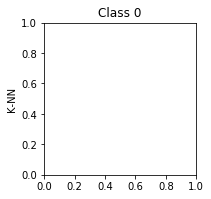

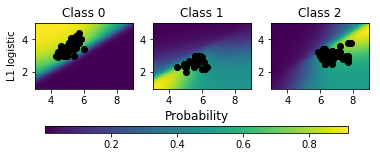

In [76]:
print(__doc__)

# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, 0:2]  # we only take the first two features for visualization
y = iris.target


#print(X)

C = 1.0

# Create different classifiers. The logistic regression cannot do
# multiclass out of the box.
classifiers = {'L1 logistic': LogisticRegression(C=C, penalty='l1')
               }

n_classifiers = len(classifiers)

plt.figure(figsize=(3 * 2, n_classifiers * 2))
plt.subplots_adjust(bottom=.2, top=.95)

xx = np.linspace(3, 9, 100)
yy = np.linspace(1, 5, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X, y)
    
    # View probabilities=
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        plt.title("Class %d" % k)
        if k == 0:
            plt.ylabel(name)
        print(len(probas[:, k]))
        imshow_handle = plt.imshow(probas[:, k].reshape((100, 100)),
                                   extent=(3, 9, 1, 5), origin='lower')
        #plt.xticks(())
        #plt.yticks(())
        idx = (y_pred == k)
        if idx.any():
            plt.scatter(X[idx, 0], X[idx, 1], marker='o', c='k')

ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

plt.show()

/home/lain/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in divide
/home/lain/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


[[ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 ..., 
 [ 0.67143726  0.32856274]
 [ 1.          0.        ]
 [ 1.          0.        ]]


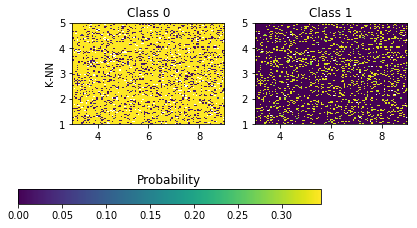

In [96]:
knn_list = KNN_best_weighted(league_table[0:10000], "first_blood", features_used_league, 3, True, True, True)[1]

new_list = []
for item in knn_list:
    if len(item) == 1: 
        new_list.append([item[0][1], 0.0])
    else: 
        new_list.append([item[0][1], item[1][1]])
#new_list.append([1.0, 0.0])        
probsarr = np.asarray(new_list)

n_classes = 2 

print(probsarr)

for index in range(0, 1):
    
    for k in range(n_classes):
        plt.subplot(1, n_classes, index * n_classes + k + 1)
        plt.title("Class %d" % k)
        if k == 0:
            plt.ylabel("K-NN")
        imshow_handle = plt.imshow(probsarr[:, k].reshape((100, 100)),
                                       extent=(3, 9, 1, 5), origin='lower')
        #plt.xticks(())
        #plt.yticks(())

ax = plt.axes([0.00, 0.05, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

plt.show()

TypeError: Cumulative distribution plots are notsupported for bivariate distributions.

In [137]:
league_table["win_ohe"] = league_table["win"].astype(int)

#print(league_table)
knn_list = KNN_best_weighted(league_table, "win_ohe", features_used_league, 9, False, False, True)[1]

print(knn_list)
prob_list = []

for i in range(len(knn_list)):
    prob_list.append(knn_list[i][0][1])

league_table["knn_pred"] = KNN_best_weighted(league_table, "win_ohe", features_used_league, 9, False, False, True)[0]
league_table["knn_pred_prob"] = prob_list
#print(league_table["knn_pred_prob"])

/home/lain/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in divide
/home/lain/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


[[(0, nan), (1, nan)], [(0, nan), (1, nan)], [(1, nan)], [(1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(1, nan)], [(1, nan)], [(0, nan), (1, nan)], [(1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(1, nan)], [(0, nan), (1, nan)], [(0, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)], [(1, nan)], [(0, nan), (1, nan)], [(0, nan), (1, nan)

/home/lain/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/home/lain/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/home/lain/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/home/lain/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:1533: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/lain/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:1534: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


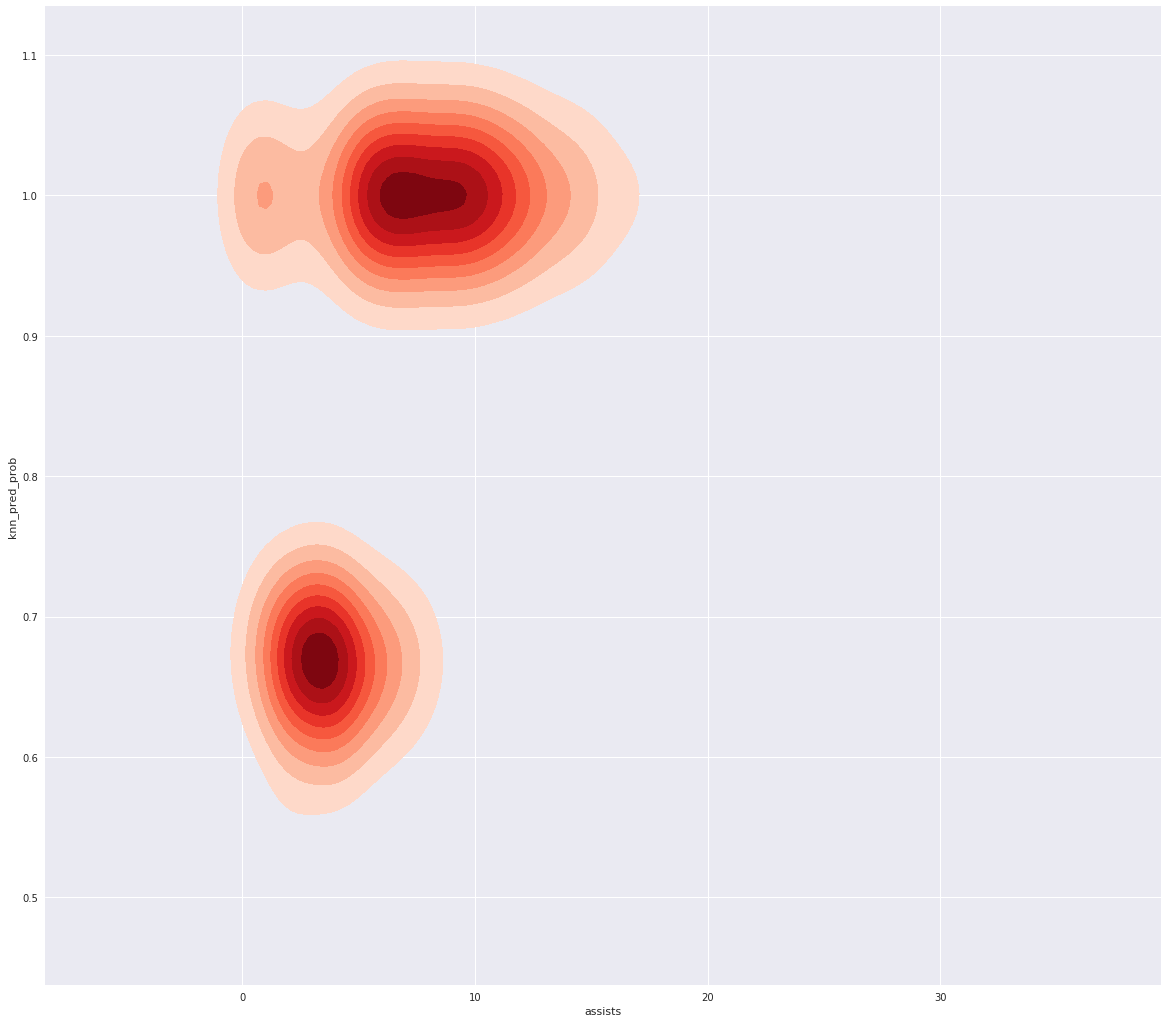

In [134]:
league_table["knn_pred_prob"] = league_table["knn_pred_prob"].fillna(1)

import seaborn as sns; sns.set(color_codes=True)

champion_name = league_table["Champion_name"]
lucian = league_table.loc[champion_name == "Lucian"]
janna = league_table.loc[champion_name == "Janna"]

ax = sns.kdeplot(lucian["assists"],lucian["knn_pred_prob"], cmap="Reds", shade=True, shade_lowest=False, legend = True)
ax = sns.kdeplot(janna["assists"],janna["knn_pred_prob"], cmap="Blues", shade=True, shade_lowest=False, legend = True)
sns.set(rc={'figure.figsize':(20,18)})
plt.show()

In [25]:
import os

week = 8  # change this each week

home_path =  os.path.expanduser('~')

file_path = '/Desktop/CIS399/'

file_name = 'loan_wrangled_w'+str(week)+'.csv'

loan_table.to_csv(home_path + file_path + file_name, index=False)